In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.decomposition import PCA
import os

2025-05-09 19:32:52.383989: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path_to_directory="MDP/"
files = [arff for arff in os.listdir(path_to_directory) if arff.endswith(".arff")]

def toCsv(content): 
    data = False
    header = ""
    newContent = []
    for line in content:
        if not data:
            if "@attribute" in line:
                attri = line.split()
                columnName = attri[attri.index("@attribute")+1]
                header = header + columnName + ","
            elif "@data" in line:
                data = True
                header = header[:-1]
                header += '\n'
                newContent.append(header)
        else:
            newContent.append(line)
    return newContent



In [3]:
# Main loop for reading and writing files
for zzzz,file in enumerate(files):
    with open(path_to_directory+file , "r") as inFile:
        content = inFile.readlines()
        name,ext = os.path.splitext(inFile.name)
        new = toCsv(content)
        with open(name+".csv", "w") as outFile:
            outFile.writelines(new)

In [4]:
cm1 = pd.read_csv('MDP/CM1.csv')
kc3 = pd.read_csv('MDP/KC3.csv')
#kc4 = pd.read_csv('MDP/KC4.csv')
mc2 = pd.read_csv('MDP/MC2.csv')
mw1 = pd.read_csv('MDP/MW1.csv')
pc1 = pd.read_csv('MDP/PC1.csv')
pc2 = pd.read_csv('MDP/PC2.csv')
pc3 = pd.read_csv('MDP/PC3.csv')
pc4 = pd.read_csv('MDP/PC4.csv')
jm1 = pd.read_csv('MDP/JM1.csv')
jm1.rename(columns={"label": "Defective"}, errors="raise", inplace=True)
kc1 = pd.read_csv('MDP/KC1.csv')
mc1 = pd.read_csv('MDP/MC1.csv')
pc5 = pd.read_csv('MDP/PC5.csv')

ar1 = pd.read_csv('SOFTLAB/ar1.csv')
ar3 = pd.read_csv('SOFTLAB/ar3.csv')
ar4 = pd.read_csv('SOFTLAB/ar4.csv')
ar5 = pd.read_csv('SOFTLAB/ar5.csv')
ar6 = pd.read_csv('SOFTLAB/ar6.csv')

In [5]:
list_softlab = ['ar1','ar3','ar4','ar5','ar6']
#index_softlab = range(0,5)
list_data_softlab = [ar1,ar3,ar4,ar5,ar6]

In [6]:
for dt in list_data_softlab:
    dt['Category'] = dt['Defective']
    dt.loc[dt['Defective'] == 'clean', 'Category'] = 'N'
    dt.loc[dt['Defective'] == 'buggy', 'Category'] = 'Y'
    dt['Defective'] = dt['Category']

In [7]:
kc1.shape

(1162, 22)

In [8]:
list_dataset = [kc1,pc2,mc1]
label_dataset = ['kc1','pc2','mc1']

list_test = [cm1,kc3,mc2,mw1,pc1,pc3,pc4,pc5,pc2,jm1,kc1,mc1] + list_dataset + list_data_softlab
label_test = ['cm1','kc3','mc2','mw1','pc1','pc3','pc4','pc5','pc2','jm1','kc1','mc1'] + label_dataset + ['ar1','ar3','ar4','ar5','ar6']

my_index = range(0,len(list_test))
my_dataset = dict(zip(label_test,list_test))

df = list_dataset
df = pd.concat(df)
df

,LOC_BLANK,BRANCH_COUNT,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_COMPLEXITY,DESIGN_COMPLEXITY,ESSENTIAL_COMPLEXITY,LOC_EXECUTABLE,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,...,PARAMETER_COUNT,MAINTENANCE_SEVERITY,MODIFIED_CONDITION_COUNT,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUMBER_OF_LINES,PERCENT_COMMENTS,GLOBAL_DATA_COMPLEXITY,GLOBAL_DATA_DENSITY
0,6.0,15,1,3,8,8,1,45,23.87,27.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,17,0,7,9,8,1,82,69.72,22.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12.0,31,0,0,16,13,10,95,59.66,33.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1,0,0,1,1,1,12,89.39,2.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1,0,0,1,1,1,3,16.84,1.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,0.0,1,0,0,1,1,1,2,7.83,4.67,...,0.0,1.0,0.0,0.0,2.0,0.17,6.0,0.00,1.0,1.0
1948,2.0,1,0,0,1,1,1,2,5.33,1.50,...,0.0,1.0,0.0,0.0,2.0,0.17,6.0,0.00,1.0,1.0
1949,8.0,1,15,10,1,1,1,20,108.08,8.29,...,0.0,1.0,0.0,0.0,7.0,0.02,55.0,55.56,0.0,0.0
1950,38.0,61,16,32,35,28,18,198,73.58,80.67,...,0.0,0.0,24.0,47.0,133.0,0.12,286.0,19.51,24.0,0.0


In [9]:
def adjustdataset(dt,dataframe):
    dt_copy = dt.copy()
    counter = 0
    
    for col in dataframe.columns:
        if not col in dt.columns:
            #print("Not Exist ",col)
            dt_copy.insert(counter,col,-1)
        counter += 1

    return dt_copy[dataframe.columns]
    

In [10]:
def show_distribution(df, columns):
    
    counter = 0
    # Create a figure and a grid of subplots with 8 rows and 5 columns
    fig, axes = plt.subplots(8, 5, figsize=(30, 20))
    
    # Loop through each subplot and add content (optional)
    for i in range(8):
        for j in range(5):
            try:
                ax = axes[i, j]
                ax.set_title(columns[counter])
                ax.plot(df[columns[counter]].sort_values(), norm.pdf(df[columns[counter]].sort_values(), df[columns[counter]].mean(), df[columns[counter]].std())) 
                ax.set_xticks([])
                ax.set_yticks([])
                counter += 1
            except:
                pass

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

<Figure size 640x480 with 0 Axes>

In [11]:
df.shape

(3836, 40)

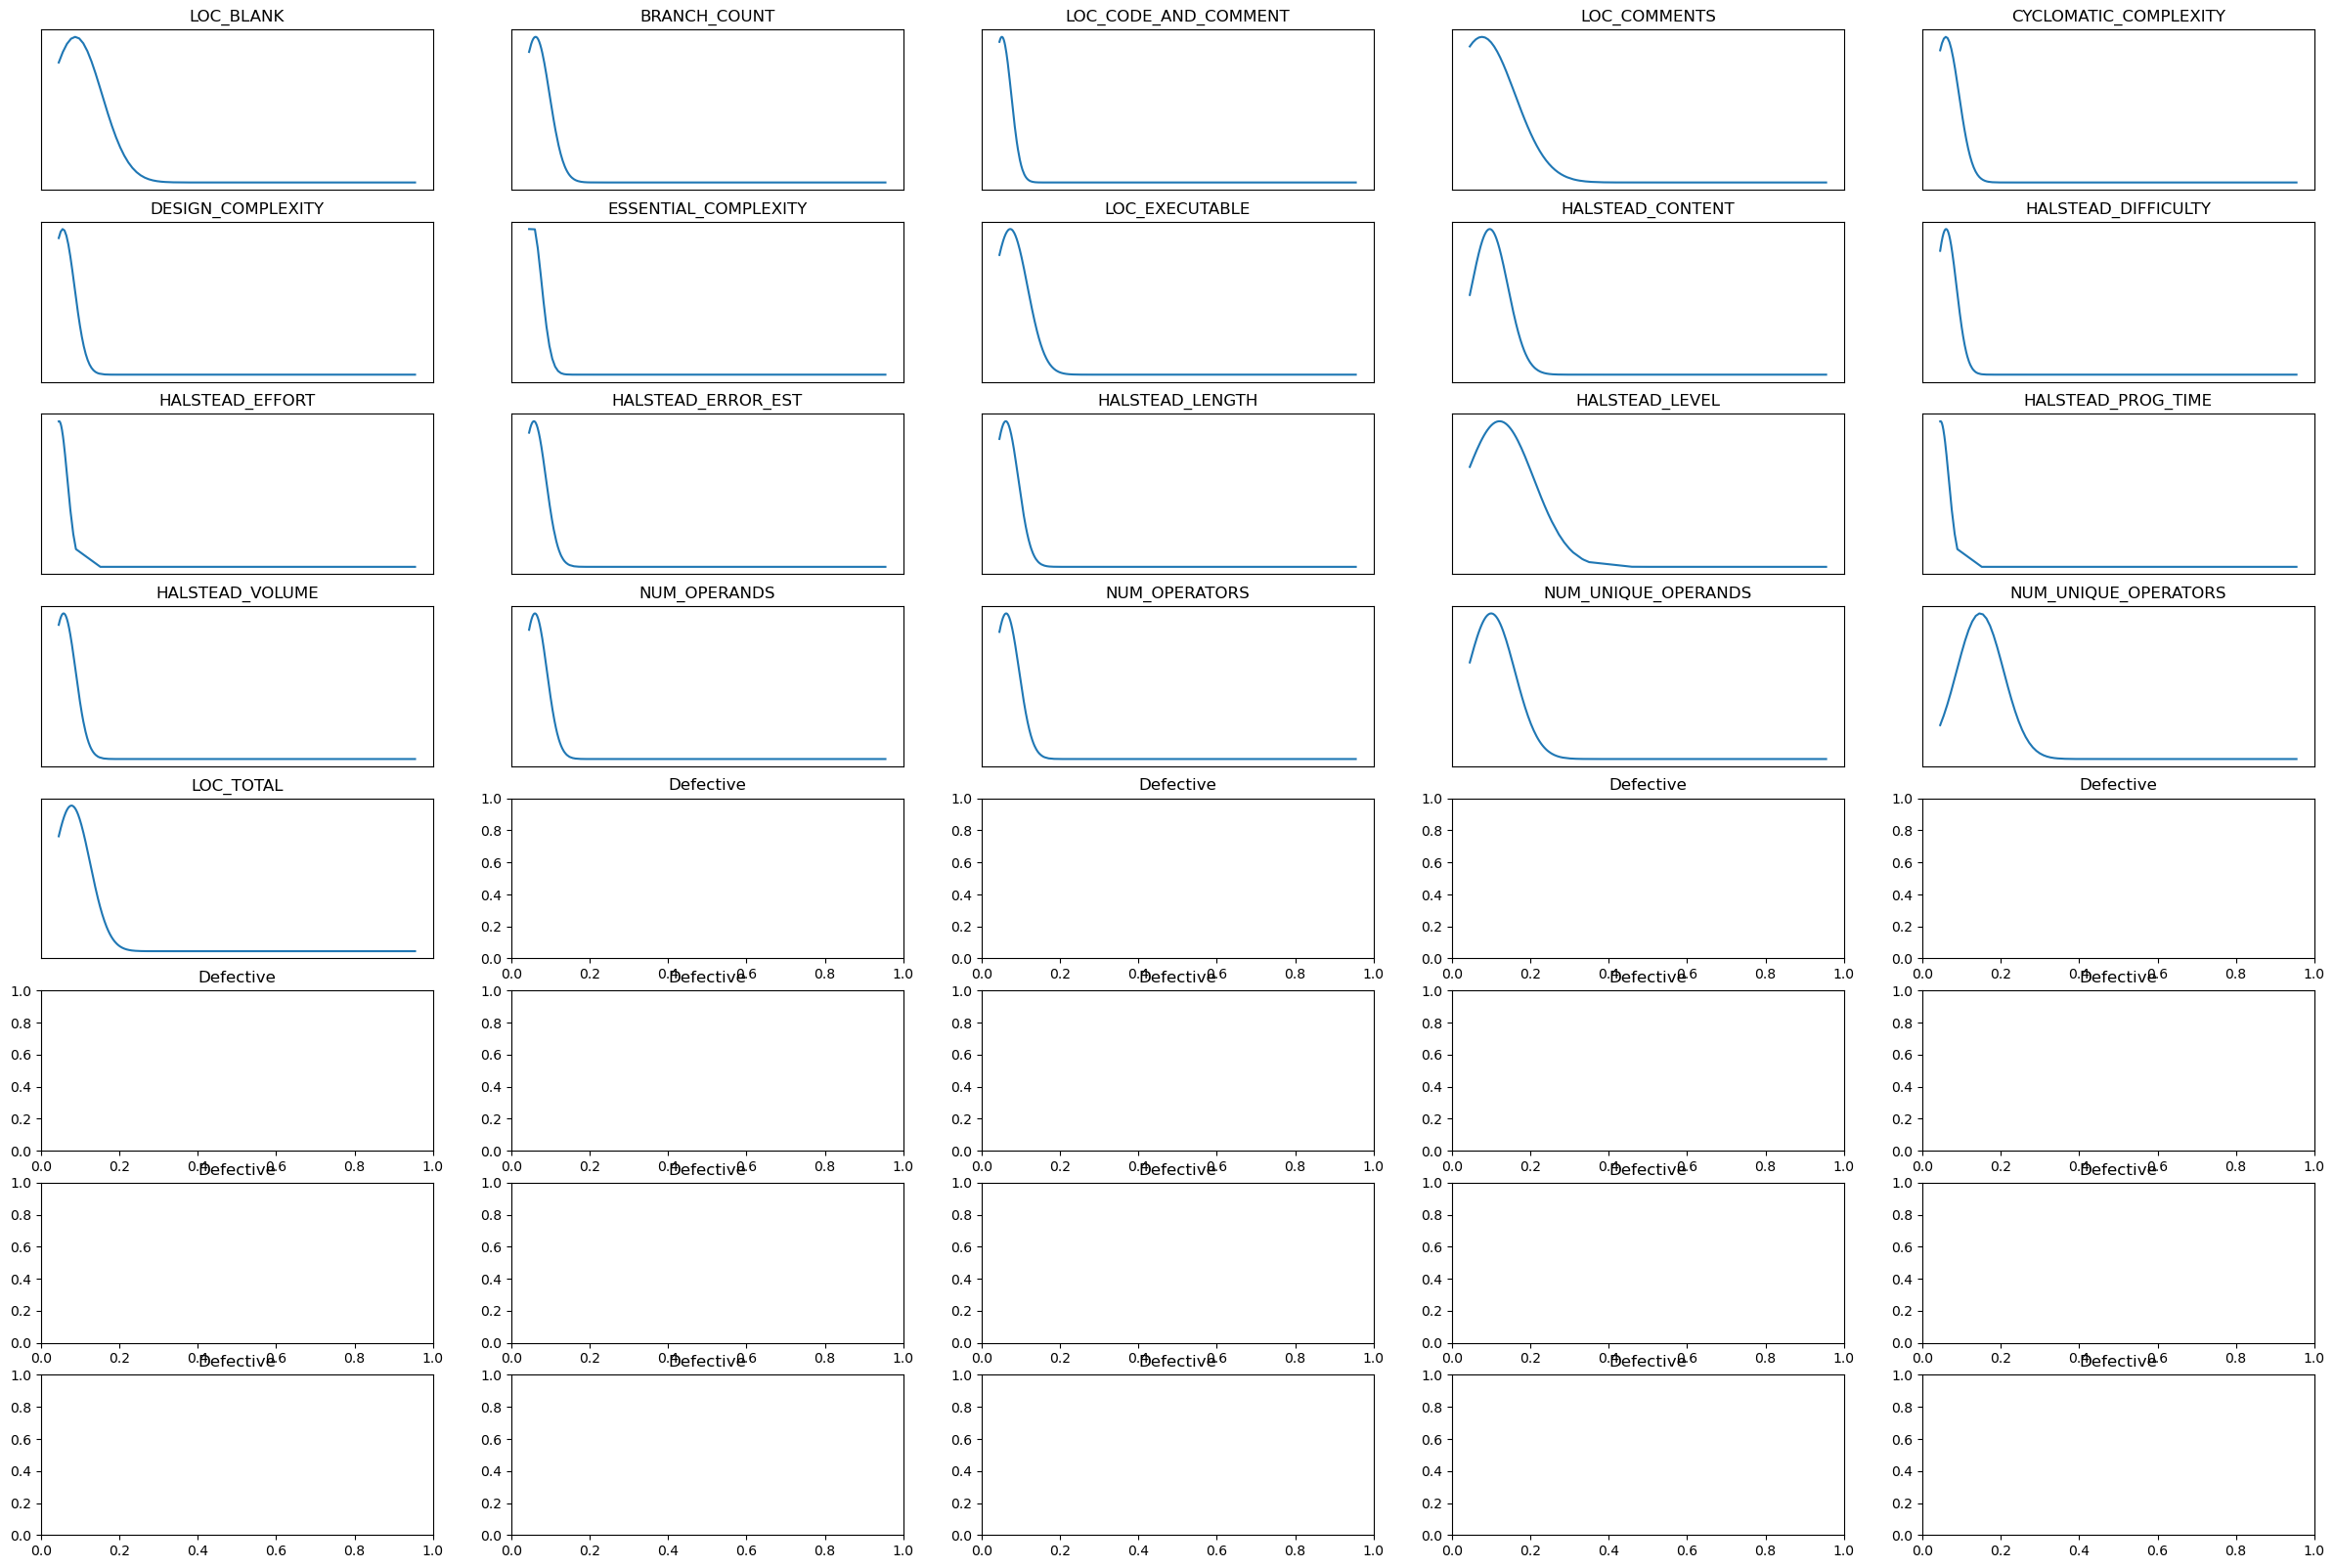

In [12]:
show_distribution(df, df.columns)

In [13]:
def preprocessing(dataframe, imputer = None, pt = None, scaler = None, show = True):
    
    df = dataframe.copy()
    
    df.loc[(df['Defective'] == 'N'),'Defective']=0
    df.loc[(df['Defective'] == 'Y'),'Defective']=1
    
    change_dtypes = ['Defective']
    dict_dtypes = {d:'int64' for d in change_dtypes }
    df = df.astype(dict_dtypes)
    
    try:
        df.loc[(df['DECISION_DENSITY'] == '?'),'DECISION_DENSITY']= -1
        
        change_dtypes = ['DECISION_DENSITY']
        dict_dtypes = {d:'float64' for d in change_dtypes }
        df = df.astype(dict_dtypes)
    
    except:
        pass
        
    
    columns = df.columns
    
    if show:
        show_distribution(df,df.columns)
    
    if imputer :
        df = imputer.transform(df)
    else:
        imputer = KNNImputer(n_neighbors=2)
        df = imputer.fit_transform(df)
    
    df = pd.DataFrame(df)
    df.columns = columns
    
    if show:
        show_distribution(df,df.columns)
    
    y = df['Defective']
    X = df.drop('Defective',axis=1)
    
    if pt:
        X_norm = pt.transform(X)
    else:
        pt = PowerTransformer()
        X_norm = pt.fit_transform(X)
    
    X_norm = pd.DataFrame(X)
    X_norm.columns = X.columns
    
    if show:
        show_distribution(X_norm,X_norm.columns)

    if scaler:
        X_norm_scale = scaler.transform(X_norm)
    else:
        scaler = MinMaxScaler()
        X_norm_scale = scaler.fit_transform(X_norm)
        
    return pt, scaler, imputer, X_norm_scale, y



In [14]:
def heat_map(y,result):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    sns.set
    _, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(confusion_matrix(y, result), annot=True, fmt='d', cmap= ['#09acec','#089dd9','#078fc5','#0681b1','#05668d','#05368d'], annot_kws={"size": 40, "weight": "bold"})  
    labels = ['No Defect','Defect']
    ax.set_xticklabels(labels, fontsize=30);
    ax.set_yticklabels(labels, fontsize=30,rotation=0);
    ax.set_ylabel('Prediction', fontsize=30,rotation=0);
    ax.set_xlabel('Ground Truth', fontsize=30) #0,1

In [15]:
def score(y,result):
    accuracy = accuracy_score(y, result)
    f1 = f1_score(y, result, average='weighted')
    precision = precision_score(y, result, average='weighted')
    recall = recall_score(y, result, average='weighted')
    print("Accuracy = " , accuracy, " Precision = ",precision, " Recall = ",recall, " F1-Score = ",f1 )

In [16]:
from sklearn.metrics import make_scorer

scorers = {
            'f1_score': make_scorer(f1_score, average='micro'),
            'precision_score': make_scorer(precision_score, average='micro'),
            'recall_score': make_scorer(recall_score, average='micro'),
            'accuracy_score': make_scorer(accuracy_score)
          }
search_space={}

In [17]:
pt, scaler, imputer, X_norm_scale, y = preprocessing(df, show=False)

In [18]:
smote = SMOTE(random_state=42)
X_norm_scale_smote, y_smote = smote.fit_resample(X_norm_scale, y) 
#X_norm_scale_smote, y_smote = X_norm_scale, y    

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [19]:
def squezee_embedded(embedd):
    list_embed = []
    for x in embedd.toarray():
        for a in np.nonzero(x == 1):
            list_embed.append(a.astype(str))
    return np.array(list_embed)

In [20]:
counter = 0
histories = []

lst_accu_stratified = []
lst_f1_stratified = []
lst_precision_stratified = []
lst_recall_stratified = []

lst_accu_stratified_val = []
lst_f1_stratified_val = []
lst_precision_stratified_val = []
lst_recall_stratified_val = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=19)

for train_index, test_index in skf.split(X_norm_scale_smote, y_smote):

    x_train_fold, x_test_fold = X_norm_scale_smote[train_index], X_norm_scale_smote[test_index]
    y_train_fold, y_test_fold = y_smote[train_index], y_smote[test_index]

    
    rte = RandomTreesEmbedding(n_estimators=5000, random_state=0, max_depth=10).fit(x_train_fold)
    x_sparse_embedding_train = rte.transform(x_train_fold)
    x_sparse_embedding_test = rte.transform(x_test_fold)
    
    with open('rte-squezee-{0}.pickle'.format(counter), 'wb') as handle:
        pickle.dump(rte, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    x_embedding_train = squezee_embedded(x_sparse_embedding_train)
    x_embedding_test = squezee_embedded(x_sparse_embedding_test)
    
    scaler_emb = MinMaxScaler()
    x_norm_scale_train = scaler_emb.fit_transform(x_embedding_train)
    x_norm_scale_test = scaler_emb.transform(x_embedding_test)
    
    with open('scaler-squezee-{0}.pickle'.format(counter), 'wb') as handle:
        pickle.dump(scaler_emb, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    input_X_train1 = layers.Input(
    shape=(x_norm_scale_train.shape[1],), name="X_train1")  
    
    input_X_train2 = layers.Input(shape=(x_train_fold.shape[1],), name="X_train2")

    layer_X_train1 = layers.Dense(512,activation='relu',name="X_train1_layer")(input_X_train1)
    layer_X_train1 = layers.BatchNormalization()(layer_X_train1)
    layer_X_train1 = layers.Dropout(0.3)(layer_X_train1)
    layer_X_train1 = layers.Dense(512,activation='relu',name="X_train1_layer")(input_X_train1)
    layer_X_train1 = layers.BatchNormalization()(layer_X_train1)
    layer_X_train1 = layers.Dropout(0.3)(layer_X_train1)

    layer_X_train2 = layers.Dense(512,activation='relu',name="X_train2_layer")(input_X_train2)
    layer_X_train2 = layers.BatchNormalization()(layer_X_train2)
    layer_X_train2 = layers.Dropout(0.3)(layer_X_train2)
    layer_X_train2 = layers.Dense(128,activation='relu',name="X_train2_layer")(input_X_train2)
    layer_X_train2 = layers.BatchNormalization()(layer_X_train2)
    layer_X_train2 = layers.Dropout(0.3)(layer_X_train2)

    # Merge all available features into a single large vector via concatenation
    concat = layers.concatenate([layer_X_train1, layer_X_train2])

    layer_final = layers.Dense(1, activation='sigmoid', name="classifier")(concat)
    sdp_classifier = Model(inputs=[input_X_train1, input_X_train2], outputs=layer_final)

    checkpointer=ModelCheckpoint(filepath='sdp-squezee-{0}.weights.best.keras'.format(counter),verbose=1,save_best_only=True)

    sdp_classifier.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'] )
    
    hist = sdp_classifier.fit([x_norm_scale_train,x_train_fold], y_train_fold, 
                    batch_size=32, epochs=100, validation_split= 0.1, callbacks=[checkpointer], 
                    verbose=2, shuffle=True)
    
    with open('sdp-squezee-classifier-{0}.pickle'.format(counter), 'wb') as handle:
        pickle.dump(sdp_classifier, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

    sdp_classifier.load_weights('sdp-squezee-{0}.weights.best.keras'.format(counter))

    histories.append(hist)

    results = sdp_classifier.predict([x_norm_scale_train, x_train_fold])
    results = np.round(results)
    
    lst_accu_stratified.append(accuracy_score(results, y_train_fold))
    lst_f1_stratified.append(f1_score(y_train_fold, results, average='weighted') )
    lst_precision_stratified.append(precision_score(results, y_train_fold, average='weighted') )
    lst_recall_stratified.append(recall_score(results, y_train_fold, average='weighted') )
    
    results = sdp_classifier.predict([x_norm_scale_test, x_test_fold])
    results = np.round(results)
    
    lst_accu_stratified_val.append(accuracy_score(results, y_test_fold))
    lst_f1_stratified_val.append(f1_score(results, y_test_fold, average='weighted') )
    lst_precision_stratified_val.append(precision_score(results, y_test_fold, average='weighted') )
    lst_recall_stratified_val.append(recall_score(results, y_test_fold, average='weighted') )

    print("Evaluate on training data")
    results = sdp_classifier.evaluate([x_norm_scale_train, x_train_fold], y_train_fold)
    print("test loss, test acc:", results)

    print("Evaluate on test data")
    results = sdp_classifier.evaluate([x_norm_scale_test, x_test_fold], y_test_fold)
    print("test loss, test acc:", results)
    counter += 1
    

dict_test = {"train_accu":lst_accu_stratified, 
           "train_precision":lst_precision_stratified, "train_recall":lst_recall_stratified, "train_f1":lst_f1_stratified,
           "test_accu":lst_accu_stratified_val, 
           "test_precision":lst_precision_stratified_val, "test_recall":lst_recall_stratified_val, 
           "test_f1":lst_f1_stratified_val,"Input": x_train_fold.shape[1] ,"RTE": x_norm_scale_train.shape[1],
            }

dict_test_result = pd.DataFrame.from_dict(dict_test)
dict_test_result.to_csv("hasil.csv")

with open('histories-squezee.pickle'.format(counter), 'wb') as handle:
        pickle.dump(histories, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.13668, saving model to sdp-squezee-0.weights.best.keras
177/177 - 5s - loss: 0.5024 - accuracy: 0.7778 - val_loss: 0.1367 - val_accuracy: 0.9825 - 5s/epoch - 26ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 0.13668
177/177 - 3s - loss: 0.3714 - accuracy: 0.8388 - val_loss: 0.6338 - val_accuracy: 0.6789 - 3s/epoch - 15ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.13668
177/177 - 2s - loss: 0.3211 - accuracy: 0.8620 - val_loss: 1.7813 - val_accuracy: 0.1399 - 2s/epoch - 14ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.13668
177/177 - 2s - loss: 0.3041 - accuracy: 0.8726 - val_loss: 1.2127 - val_accuracy: 0.3545 - 2s/epoch - 11ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.13668 to 0.07687, saving model to sdp-squezee-0.weights.best.keras
177/177 - 2s - loss: 0.2790 - accuracy: 0.8836 - val_loss: 0.0769 - val_accuracy: 0.9905 - 2s/epoch - 13ms/step
Epoch 6/100

Epoch 6: val_loss did n

In [21]:
dict_test_result

,train_accu,train_precision,train_recall,train_f1,test_accu,test_precision,test_recall,test_f1,Input,RTE
0,0.958771,0.961291,0.958771,0.958719,0.916905,0.923474,0.916905,0.917179,39,5000
1,0.858644,0.897712,0.858644,0.855827,0.819484,0.882604,0.819484,0.825367,39,5000
2,0.881566,0.909019,0.881566,0.879918,0.833811,0.876520,0.833811,0.837437,39,5000
3,0.945559,0.950879,0.945559,0.945414,0.905444,0.920222,0.905444,0.906148,39,5000
4,0.883158,0.908850,0.883158,0.881638,0.872493,0.899426,0.872493,0.874233,39,5000
5,0.869946,0.902951,0.869946,0.867764,0.861032,0.896536,0.861032,0.863543,39,5000
6,0.812321,0.881815,0.812321,0.805565,0.819484,0.882604,0.819484,0.825367,39,5000
7,0.827921,0.886924,0.827921,0.822690,0.832378,0.888572,0.832378,0.837224,39,5000
8,0.958294,0.961512,0.958294,0.958226,0.892550,0.907825,0.892550,0.893377,39,5000
9,0.931869,0.940724,0.931869,0.931566,0.879656,0.903367,0.879656,0.881100,39,5000


In [22]:
best = 1

dbfile = open('rte-squezee-{0}.pickle'.format(best), 'rb')    
rte = pickle.load(dbfile)
dbfile.close()

dbfile = open('scaler-squezee-{0}.pickle'.format(best), 'rb')    
scaler_emb = pickle.load(dbfile)
dbfile.close()

dbfile = open('sdp-squezee-classifier-{0}.pickle'.format(best), 'rb')    
sdp_classifier = pickle.load(dbfile)
dbfile.close()
sdp_classifier.load_weights('sdp-squezee-{0}.weights.best.keras'.format(best))


In [23]:
X_sparse_embedding = rte.transform(X_norm_scale_smote)
X_embedding = squezee_embedded(X_sparse_embedding)
X_norm_scale = scaler_emb.transform(X_embedding)

In [24]:
print("Evaluate on training data")
results = sdp_classifier.evaluate([X_norm_scale, X_norm_scale_smote], y_smote, batch_size=128)
print("test loss, test acc:", results)

Evaluate on training data
55/55 [==============================] - 1s 5ms/step - loss: 0.3957 - accuracy: 0.8547
test loss, test acc: [0.39572954177856445, 0.8547278046607971]


In [25]:
from sklearn.metrics import classification_report

results = sdp_classifier.predict([X_norm_scale,X_norm_scale_smote])
results=np.round(results)
print(classification_report(y_smote,results))

219/219 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83      3490
         1.0       0.78      1.00      0.87      3490

    accuracy                           0.85      6980
   macro avg       0.89      0.85      0.85      6980
weighted avg       0.89      0.85      0.85      6980



In [ ]:
list_result = []

for label in my_dataset:
    dt = adjustdataset(my_dataset[label], df)
    pt, scaler, imputer, X_norm_scale_dt, y_dt = preprocessing(dt,imputer,pt, scaler, show=False)
    
    X_sparse_embedding_dt = rte.transform(X_norm_scale_dt)
    X_embedding_dt = squezee_embedded(X_sparse_embedding_dt)
    X_scale_dt = scaler_emb.transform(X_embedding_dt)
    
    results = sdp_classifier.predict([X_scale_dt,X_norm_scale_dt])
    result  = np.round(results)
    list_result.append({'label':label, 'accuracy' : accuracy_score(y_dt, result),'precision':precision_score(y_dt, result, average='weighted'),
                  'recall': recall_score(y_dt, result, average='weighted'), 'f1-score':f1_score(y_dt, result, average='weighted')})
    heat_map(y_dt,result)


    

37/37 [==============================] - 0s 4ms/step


In [ ]:
df_result = pd.DataFrame(list_result)
df_result

In [ ]:
df_result[['accuracy','precision','recall','f1-score']].mean()

In [ ]:
sdp_classifier.summary()

In [ ]:
list_result = []

for label in my_dataset:
    dt = my_dataset[label]
    list_result.append({'Dataset':label, 'Instances':dt.shape[0], 'Features':dt.shape[1],
                        'Defective Instances': dt[dt['Defective'] == 'Y'].shape[0],
                        'Non-Defective Instances': dt[dt['Defective'] == 'N'].shape[0],})


    

In [ ]:
df_result = pd.DataFrame(list_result)
df_result

In [ ]:
mc2.columns